<a href="https://colab.research.google.com/github/fakhrul/PyTorch-2D-3D-UNet-Tutorial/blob/master/unet-pytorch-boat-additonal-synthetic-images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

References
1. https://github.com/usuyama/pytorch-unet/blob/master/pytorch_unet_resnet18_colab.ipynb
2. https://towardsdatascience.com/creating-and-training-a-u-net-model-with-pytorch-for-2d-3d-semantic-segmentation-dataset-fb1f7f80fe55

# Environment Preparation

In [2]:
import os

if not os.path.exists("unet.py"):
    if not os.path.exists("PyTorch-2D-3D-UNet-Tutorial"):
        !git clone https://github.com/fakhrul/PyTorch-2D-3D-UNet-Tutorial.git
    %cd PyTorch-2D-3D-UNet-Tutorial
!ls

Cloning into 'PyTorch-2D-3D-UNet-Tutorial'...
remote: Enumerating objects: 346, done.
remote: Counting objects: 100% (126/126), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 346 (delta 66), reused 99 (delta 45), pack-reused 220
Receiving objects: 100% (346/346), 71.28 MiB | 33.84 MiB/s, done.
Resolving deltas: 100% (69/69), done.
/content/PyTorch-2D-3D-UNet-Tutorial
Carvana		   Part5-3D-example.ipynb
carvana_model.pt   Part6-PL-example.ipynb
customdatasets.py  README.md
inference.py	   requirements.txt
lr_rate_finder.py  trainer.py
Microtubules3D	   transformations.py
Part1.ipynb	   unet_lightning.py
Part2.ipynb	   unet.py
Part3.ipynb	   unet-pytorch-boat-additonal-synthetic-images.ipynb
Part4.ipynb	   visual.py


In [3]:
import torch
if not torch.cuda.is_available():
    raise Exception('GPU not avaialable. CPU training will be too slow')
print('device name', torch.cuda.get_device_name())

Exception: ignored

In [4]:
# Install dependecies
!pip install "git+https://github.com/napari/napari.git#egg=napari[all]"
!pip install torchsummary

  Cloning https://github.com/napari/napari.git to /tmp/pip-install-6dkr27rf/napari
  Running command git clone -q https://github.com/napari/napari.git /tmp/pip-install-6dkr27rf/napari
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 3.3MB 8.0MB/s 
     |████████████████████████████████| 81kB 8.2MB/s 
     |████████████████████████████████| 215kB 37.7MB/s 
     |████████████████████████████████| 133kB 29.7MB/s 
     |████████████████████████████████| 61kB 6.1MB/s 
     |████████████████████████████████| 645kB 35.5MB/s 
     |████████████████████████████████| 1.5MB 36.5MB/s 
     |████████████████████████████████| 51kB 5.4MB/s 
     |████████████████████████████████| 10.1MB 36.3MB/s 
     |████████████████████████████████| 8.3MB 20.8MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████

If using google colab, need to run the below code

In [5]:
# if run using google colabs, need to execute this
#upload kaggle API
from google.colab import files
files.upload()



Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"fakhrul","key":"330af1e69a9504b8eaf91f2b36a11153"}'}

In [6]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 63 Jul  2 16:52 kaggle.json


In [7]:
!pip install -q kaggle

In [8]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [9]:
!kaggle datasets download -d fakhrul/boat-seagull

 98% 313M/318M [00:03<00:00, 119MB/s]
100% 318M/318M [00:03<00:00, 102MB/s]


In [10]:
!unzip boat-seagull.zip -d boat-seagull

Archive:  boat-seagull.zip
  inflating: boat-seagull/image/out_GP020175_part01_0005.png  
  inflating: boat-seagull/image/out_GP020175_part01_0007.png  
  inflating: boat-seagull/image/out_GP020175_part02_0001.png  
  inflating: boat-seagull/image/out_GP020175_part02_0008.png  
  inflating: boat-seagull/image/out_GP020175_part02_0015.png  
  inflating: boat-seagull/image/out_GP020175_part02_0019.png  
  inflating: boat-seagull/image/out_GP020175_part02_0023.png  
  inflating: boat-seagull/image/out_GP020175_part02_0027.png  
  inflating: boat-seagull/image/out_GP020175_part02_0031.png  
  inflating: boat-seagull/image/out_GP020175_part02_0040.png  
  inflating: boat-seagull/image/out_GP030175_part01_0011.png  
  inflating: boat-seagull/image/out_GP030175_part01_0013.png  
  inflating: boat-seagull/image/out_GP030175_part01_0015.png  
  inflating: boat-seagull/image/out_GP030175_part01_0018.png  
  inflating: boat-seagull/image/out_GP030175_part01_0023.png  
  inflating: boat-seagull/im

# Validate the dataset files

In [11]:
#in kaggle
#DATASET_LOCATION = '/kaggle/input/boat-seagull/'
#in google colab
DATASET_LOCATION = '/content/PyTorch-2D-3D-UNet-Tutorial/boat-seagull/'


input_images shape and range (5, 1080, 1920, 3) 0 255
target_masks shape and range (5, 1080, 1920) 0 255 [  0 255]


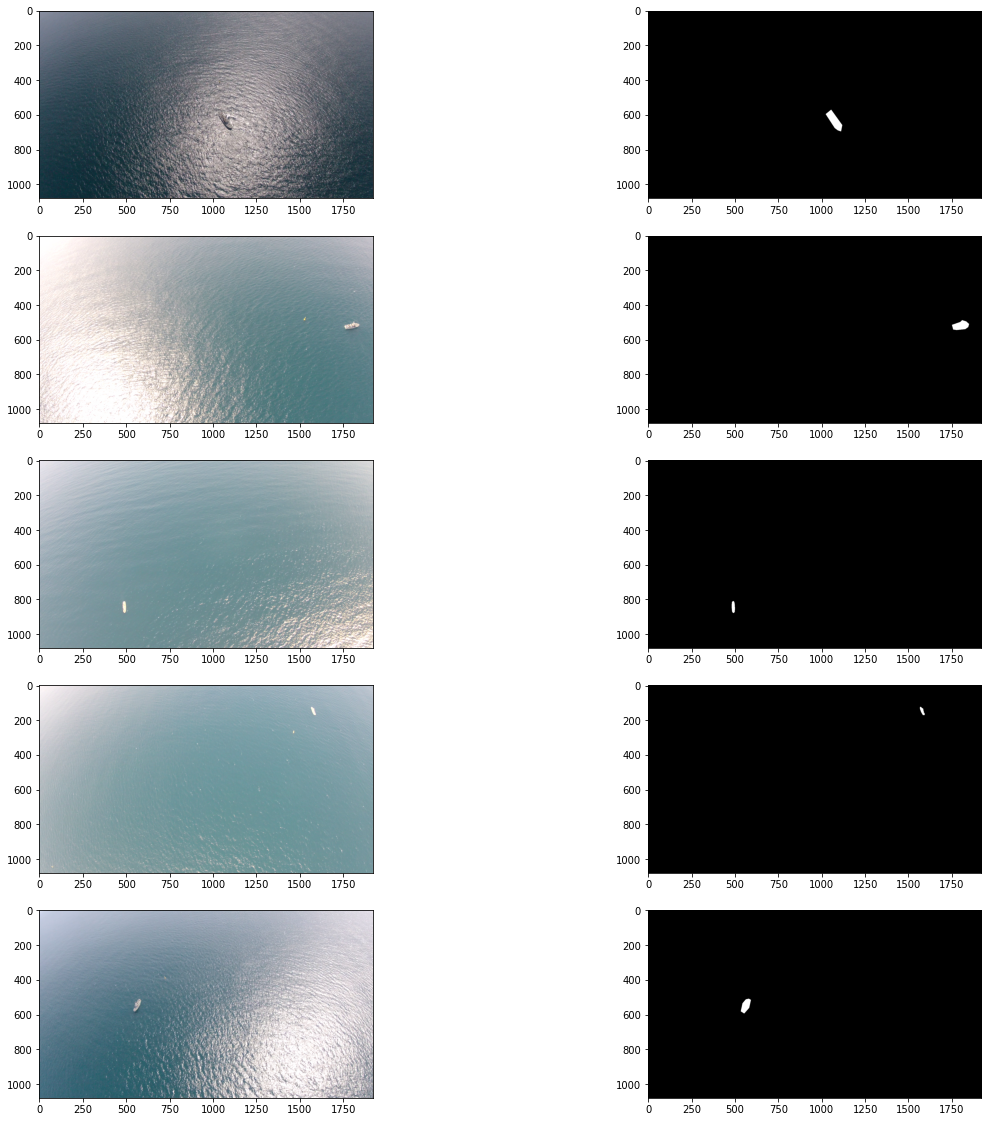

In [38]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

#DATASET_LOCATION = '/kaggle/input/boat-seagull/'
NO_OF_IMAGE = 5

image_list = []
mask_list = []
for i in range(NO_OF_IMAGE):
    file = random.choice(os.listdir(os.path.join(DATASET_LOCATION, 'image/')))
    image = cv2.imread(os.path.join(os.path.join(DATASET_LOCATION, 'image/'),file))
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    image_list.append(image)

    mask = cv2.imread(os.path.join(os.path.join(DATASET_LOCATION, 'mask/'),file))
    mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
    mask_list.append(mask)

image_list = np.array(image_list)
mask_list = np.array(mask_list)
#mask_list = mask_list.reshape(NO_OF_IMAGE, mask_list.shape[1],mask_list.shape[2], 1)
print("input_images shape and range", image_list.shape, image_list.min(), image_list.max())
print("target_masks shape and range", mask_list.shape, mask_list.min(), mask_list.max(), np.unique(mask_list))

fig, ax = plt.subplots(NO_OF_IMAGE, 2,figsize=(20,20))
for i in range(NO_OF_IMAGE):
    ax[i][0].imshow(image_list[i], cmap='gray')
    ax[i][1].imshow(mask_list[i], cmap='gray')

plt.show()

# Prepare Synthetic Data

In [48]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
import random
import shutil

class Synthetic:
    def __init__(self, image_path, mask_path):
        self.image_path = image_path
        self.mask_path = mask_path

    def crop_roi(self, image, mask):
        image_copy = image.copy()
        mask_copy = mask.copy()

        mask_copy = mask_copy.reshape(mask_copy.shape[0], mask_copy.shape[1], 1)

        image_mask = cv2.bitwise_and(image_copy, image_copy, mask=mask_copy)

        contours, _ = cv2.findContours(mask_copy, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        cnt = contours[0]
        x,y,w,h = cv2.boundingRect(cnt)

        cropped_image_mask = mask_copy[y:y+h, x:x+w]
        cropped_image = image_mask[y:y+h, x:x+w]

        cropped_image_rgba = cropped_image.copy()
        cropped_image_rgba = cv2.cvtColor(cropped_image, cv2.COLOR_RGB2RGBA)
        cropped_image_rgba[:, :, 3] = cropped_image_mask[:,:,0]

        return cropped_image_rgba, cropped_image_mask

    def overlay_transparent(self, background_img, img_to_overlay_t, x, y, overlay_size=None):
        bg_img = background_img.copy()

        if overlay_size is not None:
            img_to_overlay_t = cv2.resize(img_to_overlay_t.copy(), overlay_size)

        # Extract the alpha mask of the RGBA image, convert to RGB 
        b,g,r,a = cv2.split(img_to_overlay_t)
        overlay_color = cv2.merge((b,g,r))

        # Apply some simple filtering to remove edge noise
        mask = cv2.medianBlur(a,5)

        h, w, _ = overlay_color.shape
        roi = bg_img[y:y+h, x:x+w]

        # Black-out the area behind the logo in our original ROI
        img1_bg = cv2.bitwise_and(roi.copy(),roi.copy(),mask = cv2.bitwise_not(mask))

        # Mask out the logo from the logo image.
        img2_fg = cv2.bitwise_and(overlay_color,overlay_color,mask = mask)

        # Update the original image with our new ROI
        bg_img[y:y+h, x:x+w] = cv2.add(img1_bg, img2_fg)

        return bg_img

    def rotate_image(self, image, angle):
        height, width = image.shape[:2] # image shape has 3 dimensions
        image_center = (width/2, height/2) # getRotationMatrix2D needs coordinates in reverse order (width, height) compared to shape

        rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1.)

        # rotation calculates the cos and sin, taking absolutes of those.
        abs_cos = abs(rotation_mat[0,0]) 
        abs_sin = abs(rotation_mat[0,1])

        # find the new width and height bounds
        bound_w = int(height * abs_sin + width * abs_cos)
        bound_h = int(height * abs_cos + width * abs_sin)

        # subtract old image center (bringing image back to origo) and adding the new image center coordinates
        rotation_mat[0, 2] += bound_w/2 - image_center[0]
        rotation_mat[1, 2] += bound_h/2 - image_center[1]

        # rotate image with the new bounds and translated rotation matrix
        rotated_mat = cv2.warpAffine(image, rotation_mat, (bound_w, bound_h))
        return rotated_mat

    def clear_object(self, image, mask, radius):
        flags = cv2.INPAINT_TELEA
        # or
        #flags = cv2.INPAINT_NS
        output = cv2.inpaint(image, mask, radius, flags=flags)   
        return output

    def blend_image(self, img1, img2, img3, img4):
        blend_lr = cv2.addWeighted(img1, 0.5, img2, 0.5, 0)
        blend_tb = cv2.addWeighted(img3, 0.5, img4, 0.5, 0)
        blend_all = cv2.addWeighted(blend_tb, 0.5, blend_lr, 0.5, 0)
        return blend_all

    def crop_surrounding(self, image, mask):

        image_copy = image.copy()
        mask_copy = mask.copy()

        contours, _ = cv2.findContours(mask_copy, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        cnt = contours[0]
        x,y,w,h = cv2.boundingRect(cnt)

        MARGIN = 10

        left_image = image_copy[y:y+h, x-w-MARGIN:x-MARGIN]
        right_image = image_copy[y:y+h, x+w+-MARGIN:x+w+w+-MARGIN]
        top_image = image_copy[y-h-MARGIN:y-MARGIN, x:x+w]
        bottom_image = image_copy[y+h+MARGIN:y+h+h+MARGIN, x:x+w]

        return left_image, right_image, top_image, bottom_image

    def fix_size_if_needed(self, image, width, height):

        if image.shape[1] != width or image.shape[0] != height:
            return cv2.resize(image, (width, height))
        return image

    def replace_mask_with_surronding(self, image, mask):

        image_copy = image.copy()
        mask_copy = mask.copy()

        contours, _ = cv2.findContours(mask_copy, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        cnt = contours[0]
        x,y,w,h = cv2.boundingRect(cnt)

        l_img, r_img, t_img, b_img = self.crop_surrounding(image_copy, mask_copy)

        l_img = self.fix_size_if_needed(l_img, w, h)
        r_img = self.fix_size_if_needed(r_img, w, h)
        t_img = self.fix_size_if_needed(t_img, w, h)
        b_img = self.fix_size_if_needed(b_img, w, h)


        #print(l_img.shape, r_img.shape, t_img.shape, b_img.shape)
        blended_image = self.blend_image(l_img, r_img, t_img, b_img)

        image_copy[y:y+h, x:x+w] = blended_image
        
        
        return image_copy

    def generate_single(self, image, mask, save_path=None):
        
        synthetic_images = []
        synthetic_masks = []

        cropped_image, cropped_mask = self.crop_roi(image, mask)

        rotation_degree = random.randint(0,360)
        rotated_image = self.rotate_image(cropped_image,rotation_degree)
        rotated_mask = self.rotate_image(cropped_mask,rotation_degree)

        background = self.replace_mask_with_surronding(image, mask)
        background_mask = np.zeros((background.shape[0],background.shape[1]))

        object_size_w = rotated_image.shape[1]
        object_size_h = rotated_image.shape[0]
        object_pos_x = random.randint(0, background.shape[1] - object_size_w)
        object_pos_y = random.randint(0, background.shape[0] - object_size_h)
        
        background = self.overlay_transparent(background, rotated_image, object_pos_x, object_pos_y)
        
        background_mask[object_pos_y:object_pos_y+object_size_h, object_pos_x:object_pos_x+object_size_w] = rotated_mask
 
        return background,background_mask 
                                           
    def generate_all(self, total=100, save_path=None):
        
        synthetic_images = []
        synthetic_masks = []
        
        image_folder = ''
        mask_folder = ''
        if save_path is not None:
            if os.path.exists(save_path):
                shutil.rmtree(save_path)
            os.makedirs(save_path)
            image_folder = os.path.join(save_path, 'image/')
            if not os.path.exists(image_folder):
                os.makedirs(image_folder)
            mask_folder = os.path.join(save_path, 'mask/')
            if not os.path.exists(mask_folder):
                os.makedirs(mask_folder)
        
        i = 1
        while len(synthetic_images) < total:
        #for i in range(total):
            try:

                file = random.choice(os.listdir(self.image_path))
                #file = os.listdir(self.image_path)[index]

                image = cv2.imread(os.path.join(self.image_path,file))
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                mask = cv2.imread(os.path.join(self.mask_path,file))
                mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

                new_image, new_mask = self.generate_single(image, mask)

                if save_path is None:
                    synthetic_images.append(new_image)
                    synthetic_masks.append(new_mask)
                else:

                    full_path_image = os.path.join(image_folder, "s"+ str(i) + ".png")
                    full_path_mask =  os.path.join(mask_folder, "s"+ str(i) + ".png")

                    cv2.imwrite(full_path_image, new_image)
                    cv2.imwrite(full_path_mask, new_mask, [cv2.IMWRITE_PNG_BILEVEL, 1])

                    synthetic_images.append(full_path_image)
                    synthetic_masks.append(full_path_mask)
                
                i += 1
            except:
                print('error')
        return synthetic_images,synthetic_masks 

error
error
error
error
/content/synthtetic/image/s1.png
/content/synthtetic/image/s2.png
/content/synthtetic/image/s3.png
/content/synthtetic/image/s4.png
/content/synthtetic/image/s5.png
/content/synthtetic/image/s6.png
/content/synthtetic/image/s7.png
/content/synthtetic/image/s8.png
/content/synthtetic/image/s9.png
/content/synthtetic/image/s10.png
/content/synthtetic/image/s11.png
/content/synthtetic/image/s12.png
/content/synthtetic/image/s13.png
/content/synthtetic/image/s14.png
/content/synthtetic/image/s15.png
/content/synthtetic/image/s16.png
/content/synthtetic/image/s17.png
/content/synthtetic/image/s18.png
/content/synthtetic/image/s19.png
/content/synthtetic/image/s20.png
/content/synthtetic/image/s21.png
/content/synthtetic/image/s22.png
/content/synthtetic/image/s23.png
/content/synthtetic/image/s24.png
/content/synthtetic/image/s25.png
/content/synthtetic/image/s26.png
/content/synthtetic/image/s27.png
/content/synthtetic/image/s28.png
/content/synthtetic/image/s29.png

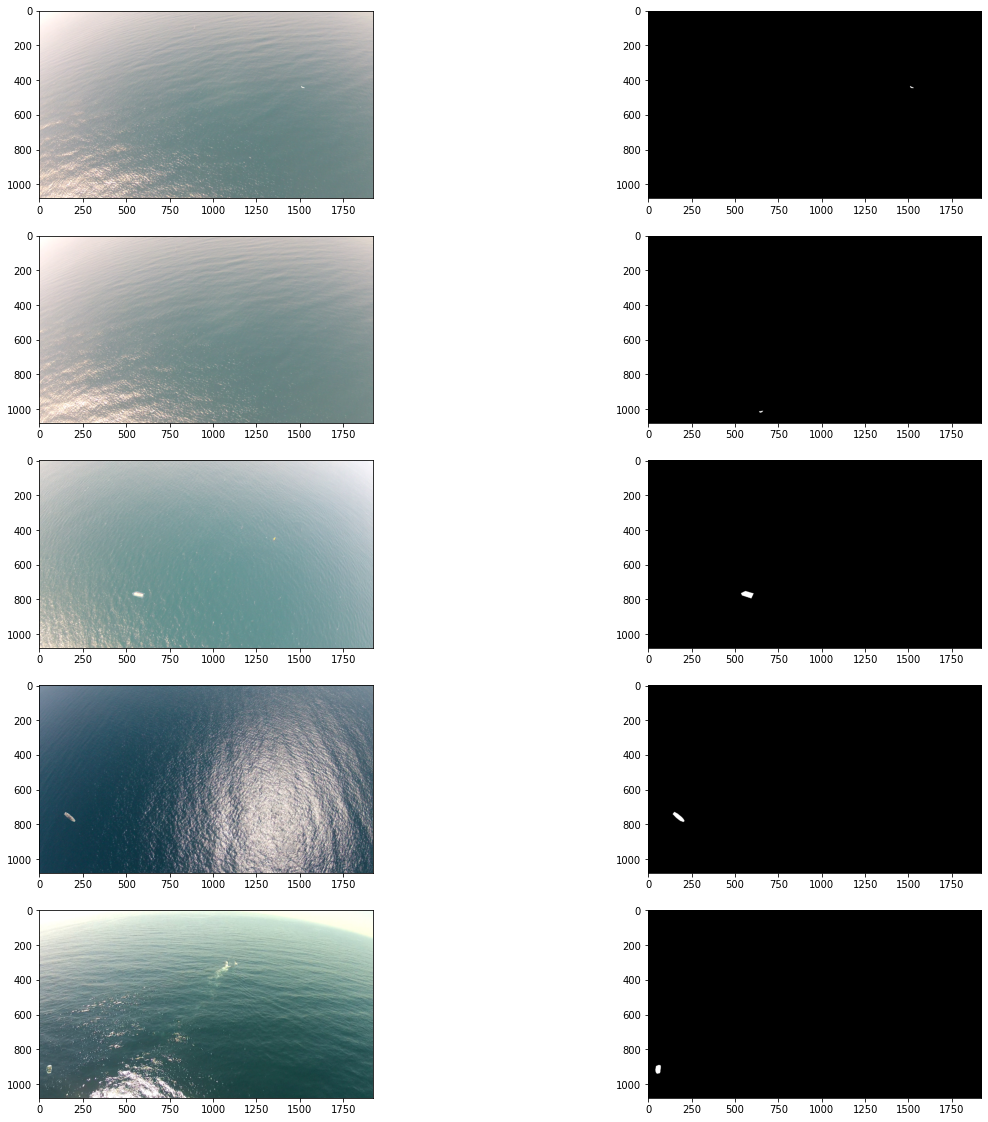

In [49]:
import random

image_path = os.path.join(DATASET_LOCATION, 'image/')
mask_path = os.path.join(DATASET_LOCATION, 'mask/') 

#synthetic_folder = '/kaggle/working/synthtetic/' # for kaggle
synthetic_folder = '/content/synthtetic/'

synthetic = Synthetic(image_path,mask_path)
generated_image, generated_mask = synthetic.generate_all(total=100, save_path=synthetic_folder)

total_file = len(generated_image)

max_image_to_plot = 5

fig, ax = plt.subplots(max_image_to_plot, 2,figsize=(20,20))
for index in range(total_file):
    print(generated_image[index])
    if index < max_image_to_plot:
        image = cv2.imread(generated_image[index])
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(generated_mask[index])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

        if total_file == 1:
            ax[0].imshow(image, cmap='gray')
            ax[1].imshow(mask, cmap='gray')

        else:
            ax[index][0].imshow(image, cmap='gray')
            ax[index][1].imshow(mask, cmap='gray')
        

plt.show()

# Prepare Data Loader

In [50]:
import numpy as np

from transformations import ComposeDouble, FunctionWrapperDouble, create_dense_target, normalize_01
from customdatasets import SegmentationDataSet1
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import pathlib
from skimage.transform import resize

# root directory
#root = '/kaggle/input/boat-seagull/'


def get_filenames_of_path(path: str, ext: str = '*'):
    full_path_list = [os.path.join(path, file_name) for file_name in os.listdir(path)]
    return  full_path_list
    """Returns a list of files in a directory/path. Uses pathlib."""
#    filenames = [file for file in path.glob(ext) if file.is_file()]
#    return filenames


# input and target files
inputs = get_filenames_of_path(os.path.join(DATASET_LOCATION,'image'))
targets = get_filenames_of_path(os.path.join(DATASET_LOCATION,'mask'))

inputs.extend(generated_image)
targets.extend(generated_mask)

#generated_image, generated_mask

# training transformations and augmentations
transforms = ComposeDouble([
    FunctionWrapperDouble(create_dense_target, input=False, target=True),
    FunctionWrapperDouble(np.moveaxis, input=True, target=False, source=-1, destination=0),
    FunctionWrapperDouble(normalize_01)
])

# random seed
random_seed = 42

# split dataset into training set and validation set
train_size = 0.8  # 80:20 split

inputs_train, inputs_valid = train_test_split(
    inputs,
    random_state=random_seed,
    train_size=train_size,
    shuffle=True)

targets_train, targets_valid = train_test_split(
    targets,
    random_state=random_seed,
    train_size=train_size,
    shuffle=True)

# dataset training
dataset_train = SegmentationDataSet1(inputs=inputs_train,
                                    targets=targets_train,
                                    transform=transforms)

# dataset validation
dataset_valid = SegmentationDataSet1(inputs=inputs_valid,
                                    targets=targets_valid,
                                    transform=transforms)

# dataloader training
dataloader_training = DataLoader(dataset=dataset_train,
                                 batch_size=2,
                                 shuffle=True)

# dataloader validation
dataloader_validation = DataLoader(dataset=dataset_valid,
                                   batch_size=2,
                                   shuffle=True)


In [51]:
x, y = next(iter(dataloader_training))

print(f'x = shape: {x.shape}; type: {x.dtype}')
print(f'x = min: {x.min()}; max: {x.max()}')
print(f'y = shape: {y.shape}; class: {y.unique()}; type: {y.dtype}')

x = shape: torch.Size([2, 3, 1080, 1920]); type: torch.float32
x = min: 0.0; max: 1.0
y = shape: torch.Size([2, 1080, 1920]); class: tensor([0, 1]); type: torch.int64


Test the data loader

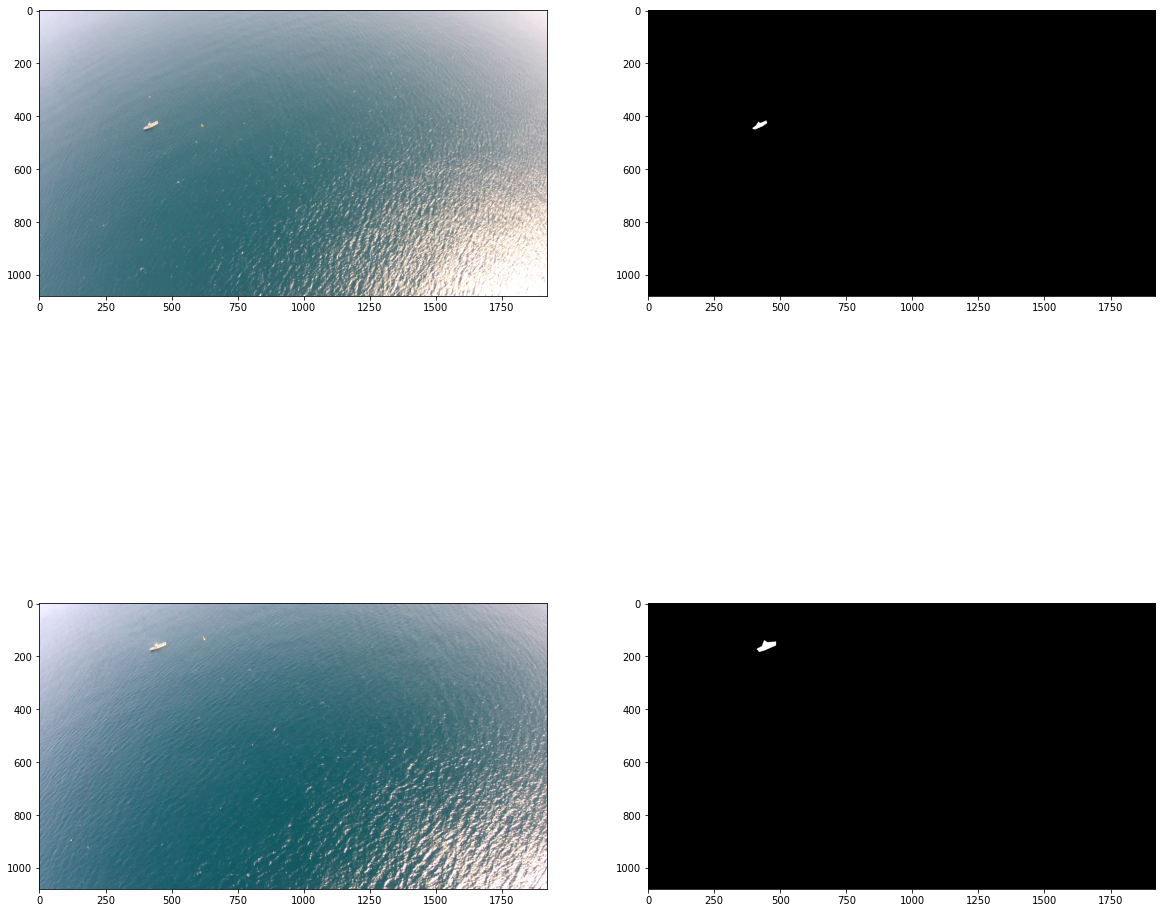

In [52]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2,2, figsize=(20,20))
ax[0][0].imshow(x[0].permute(1,2,0), cmap='gray')
ax[0][1].imshow(y[0], cmap='gray')
ax[1][0].imshow(x[1].permute(1,2,0), cmap='gray')
ax[1][1].imshow(y[1], cmap='gray')

plt.show()

# Prepare Architecture

In [53]:
import torch
from unet import UNet

#IMAGE_SIZE = (1080, 1920)
IMAGE_SIZE = (536, 960)
#IMAGE_SIZE = (270, 480)

model = UNet(in_channels=1,
             out_channels=2,
             n_blocks=4,
             start_filters=32,
             activation='relu',
             normalization='batch',
             conv_mode='same',
             dim=2)

x = torch.randn(size=(1, 1, IMAGE_SIZE[0], IMAGE_SIZE[1]), dtype=torch.float32)
with torch.no_grad():
    out = model(x)

print(f'Out: {out.shape}')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Out: torch.Size([1, 2, 536, 960])


In [54]:
from torchsummary import summary
summary = summary(model, (1, IMAGE_SIZE[0], IMAGE_SIZE[1]), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 536, 960]             320
              ReLU-2         [-1, 32, 536, 960]               0
       BatchNorm2d-3         [-1, 32, 536, 960]              64
            Conv2d-4         [-1, 32, 536, 960]           9,248
              ReLU-5         [-1, 32, 536, 960]               0
       BatchNorm2d-6         [-1, 32, 536, 960]              64
         MaxPool2d-7         [-1, 32, 268, 480]               0
         DownBlock-8  [[-1, 32, 268, 480], [-1, 32, 536, 960]]               0
            Conv2d-9         [-1, 64, 268, 480]          18,496
             ReLU-10         [-1, 64, 268, 480]               0
      BatchNorm2d-11         [-1, 64, 268, 480]             128
           Conv2d-12         [-1, 64, 268, 480]          36,928
             ReLU-13         [-1, 64, 268, 480]               0
      BatchNorm2d-14    

# Training

In [55]:
# Imports
import pathlib
from transformations import ComposeDouble, normalize_01, AlbuSeg2d, FunctionWrapperDouble, create_dense_target
from sklearn.model_selection import train_test_split
from customdatasets import SegmentationDataSet3
import torch
import numpy as np
from unet import UNet
from trainer import Trainer
from torch.utils.data import DataLoader
from skimage.transform import resize
import albumentations

# root directory
#root = '/kaggle/input/boat-seagull/'


def get_filenames_of_path(path: str, ext: str = '*'):
    full_path_list = [os.path.join(path, file_name) for file_name in os.listdir(path)]
    return  full_path_list


# input and target files
inputs = get_filenames_of_path(os.path.join(DATASET_LOCATION,'image'))
targets = get_filenames_of_path(os.path.join(DATASET_LOCATION,'mask'))

inputs.extend(generated_image)
targets.extend(generated_mask)

# pre-transformations
pre_transforms = ComposeDouble([
    FunctionWrapperDouble(resize,
                          input=True,
                          target=False,
                          output_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
    FunctionWrapperDouble(resize,
                          input=False,
                          target=True,
                          output_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1]),
                          order=0,
                          anti_aliasing=False,
                          preserve_range=True),
])

# training transformations and augmentations
transforms_training = ComposeDouble([
    AlbuSeg2d(albumentations.HorizontalFlip(p=0.5)),
    FunctionWrapperDouble(create_dense_target, input=False, target=True),
    FunctionWrapperDouble(np.moveaxis, input=True, target=False, source=-1, destination=0),
    FunctionWrapperDouble(normalize_01)
])

# validation transformations
transforms_validation = ComposeDouble([
    FunctionWrapperDouble(resize,
                          input=True,
                          target=False,
                          output_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
    FunctionWrapperDouble(resize,
                          input=False,
                          target=True,
                          output_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1]),
                          order=0,
                          anti_aliasing=False,
                          preserve_range=True),
    FunctionWrapperDouble(create_dense_target, input=False, target=True),
    FunctionWrapperDouble(np.moveaxis, input=True, target=False, source=-1, destination=0),
    FunctionWrapperDouble(normalize_01)
])

# random seed
random_seed = 42

# split dataset into training set and validation set
train_size = 0.8  # 80:20 split

inputs_train, inputs_valid = train_test_split(
    inputs,
    random_state=random_seed,
    train_size=train_size,
    shuffle=True)

targets_train, targets_valid = train_test_split(
    targets,
    random_state=random_seed,
    train_size=train_size,
    shuffle=True)

# inputs_train, inputs_valid = inputs[:80], inputs[80:]
# targets_train, targets_valid = targets[:80], targets[:80]

# dataset training
dataset_train = SegmentationDataSet3(inputs=inputs_train,
                                    targets=targets_train,
                                    transform=transforms_training,
                                    use_cache=True,
                                    pre_transform=pre_transforms)

# dataset validation
dataset_valid = SegmentationDataSet3(inputs=inputs_valid,
                                    targets=targets_valid,
                                    transform=transforms_validation,
                                    use_cache=True,
                                    pre_transform=pre_transforms)

# dataloader training
dataloader_training = DataLoader(dataset=dataset_train,
                                 batch_size=2,
                                 shuffle=True)

# dataloader validation
dataloader_validation = DataLoader(dataset=dataset_valid,
                                   batch_size=2,
                                   shuffle=True)

In [1]:
# device
device = 'cpu'
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    torch.device('cpu')

# model
model = UNet(in_channels=3,
             out_channels=2,
             n_blocks=4,
             start_filters=32,
             activation='relu',
             normalization='batch',
             conv_mode='same',
             dim=2).to(device)

# criterion
criterion = torch.nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# trainer
trainer = Trainer(model=model,
                  device=device,
                  criterion=criterion,
                  optimizer=optimizer,
                  training_DataLoader=dataloader_training,
                  validation_DataLoader=dataloader_validation,
                  lr_scheduler=None,
                  epochs=100,
                  epoch=0,
                  notebook=True)

# start training
training_losses, validation_losses, lr_rates = trainer.run_trainer()

NameError: ignored

In [ ]:
from visual import plot_training
fig = plot_training(training_losses, validation_losses, lr_rates, gaussian=True, sigma=1, figsize=(10, 4))

In [ ]:
# save the model
model_name =  'boat_model.pt'
torch.save(model.state_dict(), pathlib.Path.cwd() / model_name)

# Learning Rate Finder

In [ ]:
# device
device = 'cpu'
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    torch.device('cpu')

# model
model = UNet(in_channels=3,
             out_channels=2,
             n_blocks=4,
             start_filters=32,
             activation='relu',
             normalization='batch',
             conv_mode='same',
             dim=2).to(device)

# criterion
criterion = torch.nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [ ]:
from lr_rate_finder import LearningRateFinder
lrf = LearningRateFinder(model, criterion, optimizer, device)
lrf.fit(dataloader_training, steps=1000)

In [ ]:
lrf.plot()

Based on the picture, the best curve is at 10-2 = 0.01


# Test Prediction

In [ ]:
!ls

In [ ]:
# Imports
import pathlib

import numpy as np
import torch
from skimage.io import imread
from skimage.transform import resize

from inference import predict
from transformations import normalize_01, re_normalize
from unet import UNet

# root directory
#root = '/kaggle/input/boat-seagull/'

def get_filenames_of_path(path: str, ext: str = '*'):
    full_path_list = [os.path.join(path, file_name) for file_name in os.listdir(path)]
    return  full_path_list
    """Returns a list of files in a directory/path. Uses pathlib."""
#    filenames = [file for file in path.glob(ext) if file.is_file()]
#    return filenames


# input and target files
images_names = get_filenames_of_path(os.path.join(DATASET_LOCATION,'test'))

# read images and store them in memory
images = [imread(img_name) for img_name in images_names]

# Resize images and targets
images_res = [resize(img, (128, 128, 3)) for img in images]
print(len(images_res))
#resize_kwargs = {'order': 0, 'anti_aliasing': False, 'preserve_range': True}
#targets_res = [resize(tar, (128, 128), **resize_kwargs) for tar in targets]

In [ ]:
import pathlib

import numpy as np
import torch
from skimage.io import imread
from skimage.transform import resize

from inference import predict
from transformations import normalize_01, re_normalize
from unet import UNet

device = 'cpu'
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    torch.device('cpu')

# model
model = UNet(in_channels=3,
             out_channels=2,
             n_blocks=4,
             start_filters=32,
             activation='relu',
             normalization='batch',
             conv_mode='same',
             dim=2).to(device)


model_name = 'boat_model.pt'
model_weights = torch.load(pathlib.Path.cwd() / model_name)

model.load_state_dict(model_weights)

In [ ]:
# preprocess function
def preprocess(img: np.ndarray):
    img = np.moveaxis(img, -1, 0)  # from [H, W, C] to [C, H, W]
    img = normalize_01(img)  # linear scaling to range [0-1]
    img = np.expand_dims(img, axis=0)  # add batch dimension [B, C, H, W]
    img = img.astype(np.float32)  # typecasting to float32
    return img


# postprocess function
def postprocess(img: torch.tensor):
    img = torch.argmax(img, dim=1)  # perform argmax to generate 1 channel
    img = img.cpu().numpy()  # send to cpu and transform to numpy.ndarray
    img = np.squeeze(img)  # remove batch dim and channel dim -> [H, W]
    img = re_normalize(img)  # scale it to the range [0-255]
    return img


In [ ]:
# predict the segmentation maps 
output = [predict(img, model, preprocess, postprocess, device) for img in images_res]

In [ ]:
#from visual import enable_gui_qt
#enable_gui_qt()
#import napari

#viewer = napari.Viewer()
import matplotlib.pyplot as plt

idx = 2
#img_nap = viewer.add_image(images_res[idx], name='Input')
#tar_nap = viewer.add_labels(targets_res[idx], name='Target')
#out_nap = viewer.add_labels(output[idx], name='Prediction')
TOTAL_IMAGE = len(images_res)
fig, ax = plt.subplots(TOTAL_IMAGE,2, figsize=(20,20))

for i in range(TOTAL_IMAGE):
    ax[i][0].imshow(images_res[i], cmap='gray')
    ax[i][1].imshow(output[i], cmap='gray')

plt.show()
